# Import all libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn.metrics as metrics
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

# Read Data from CSV

In [2]:
df_housing = pd.read_csv('train.csv')

In [3]:
df_housing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Analyze the target variable 'SalePrice'. It is +ve skewed and having large values. So taking log.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

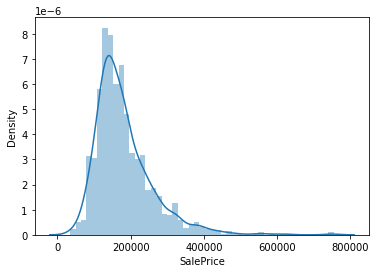

In [4]:
sns.distplot(df_housing['SalePrice'])

In [5]:
df_housing['SalePrice'] = np.log(df_housing['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

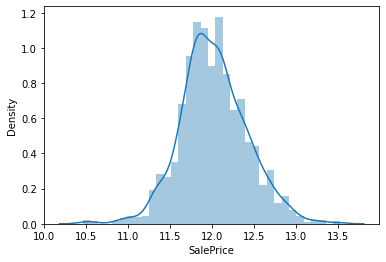

In [6]:
sns.distplot(df_housing['SalePrice'])

<AxesSubplot:xlabel='SalePrice'>

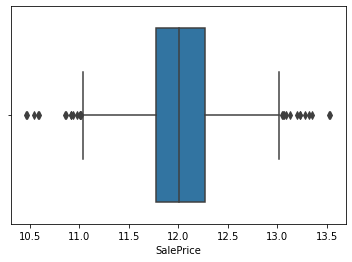

In [7]:
sns.boxplot(df_housing['SalePrice'])

In [8]:
df_housing['SalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

# Analyze the data on every columns and remove all columns where we have lot of NULL values.

In [9]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Remove Id as it has unique identifier.

In [10]:
df_housing = df_housing.drop('Id',axis=1)

### Alley have 91 records

In [11]:
df_housing = df_housing.drop('Alley',axis=1)

### FireplaceQu 770 records

In [12]:
df_housing = df_housing.drop('FireplaceQu',axis=1)

### PoolQC 7 records

In [13]:
df_housing = df_housing.drop('PoolQC',axis=1)

### Fence 281 records

In [14]:
df_housing = df_housing.drop('Fence',axis=1)

### MiscFeature 54 records

In [15]:
df_housing = df_housing.drop('MiscFeature',axis=1)

# Convert all ordinal categorical columns to numerical columns.

In [16]:
categorical_mapping_dict = {
'LotShape': {'Reg':3,'IR1':2,'IR2':1,'IR3':0},
'Street': {'Grvl': 1,'Pave': 0},
'Utilities': {'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0},
'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
'BsmtExposure' :{'Gd':4,'Av':3,'Mn':2,'No':1,'None':0},
'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
'PavedDrive' : {'Y':2,'P':1,'N':0}
}

# Replace null value to None for all categorical column

In [17]:
for col in categorical_mapping_dict:    
    df_housing[col].fillna('None',inplace=True)

### Make sure all ordinal columns are converted to either int or float.

In [18]:
for col,mapping in categorical_mapping_dict.items():
    df_housing[col] = df_housing[col].map(mapping)
    if df_housing[col].dtype != 'int64' and df_housing[col].dtype != 'float64':
        print(col)

# Verify all ordinal columns don't have any null value.

In [19]:
df_housing[list(categorical_mapping_dict.keys())].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LotShape      1460 non-null   int64
 1   Street        1460 non-null   int64
 2   Utilities     1460 non-null   int64
 3   ExterQual     1460 non-null   int64
 4   ExterCond     1460 non-null   int64
 5   BsmtQual      1460 non-null   int64
 6   BsmtCond      1460 non-null   int64
 7   BsmtExposure  1460 non-null   int64
 8   BsmtFinType1  1460 non-null   int64
 9   BsmtFinType2  1460 non-null   int64
 10  HeatingQC     1460 non-null   int64
 11  KitchenQual   1460 non-null   int64
 12  GarageFinish  1460 non-null   int64
 13  GarageQual    1460 non-null   int64
 14  GarageCond    1460 non-null   int64
 15  PavedDrive    1460 non-null   int64
dtypes: int64(16)
memory usage: 182.6 KB


# Convert YearBuilt to house_age
### We have data upto 2010 year, so substrating this column from 2011 year to get age with respective to 2011 year.

In [20]:
df_housing['HouseAge'] = 2011 - df_housing['YearBuilt']
df_housing = df_housing.drop('YearBuilt',axis = 1)
df_housing['HouseAge'].describe()

count    1460.000000
mean       39.732192
std        30.202904
min         1.000000
25%        11.000000
50%        38.000000
75%        57.000000
max       139.000000
Name: HouseAge, dtype: float64

# Analyze YearRemodAdd column

In [21]:
df_housing['RemodAge'] = 2011 - df_housing['YearRemodAdd']
df_housing = df_housing.drop('YearRemodAdd',axis = 1)
df_housing['RemodAge'].describe()

count    1460.000000
mean       26.134247
std        20.645407
min         1.000000
25%         7.000000
50%        17.000000
75%        44.000000
max        61.000000
Name: RemodAge, dtype: float64

# Analyze YrSold and MoSold

In [22]:
df_housing['SoldAge'] =  (2011 - df_housing['YrSold']) * 12  - df_housing['MoSold']
df_housing = df_housing.drop('YrSold',axis = 1)
df_housing = df_housing.drop('MoSold',axis = 1)
df_housing['SoldAge'].describe()

count    1460.000000
mean       31.889041
std        15.771632
min         5.000000
25%        18.000000
50%        31.000000
75%        44.000000
max        59.000000
Name: SoldAge, dtype: float64

In [23]:
df_housing['GarageAge'] =  2011 - df_housing['GarageYrBlt']
df_housing = df_housing.drop('GarageYrBlt',axis = 1)

# Divide columns into numerical and Categorical

In [24]:
numerical_columns = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','HouseAge','RemodAge','SoldAge','SalePrice','GarageAge','OverallQual','OverallCond','LotShape','Street','Utilities','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive']
categorical_columns = ['MSSubClass','MSZoning','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','Functional','GarageType','SaleType','SaleCondition']

# Below cell is to answer question # 3, remove 5 most important columns and re run the whole notebook

In [25]:
##### 1. GrLivArea
##### 2. OverallQual
##### 3. HouseAge
##### 4. TotalBsmtSF
##### 5. OverallCond

# df_housing.drop('GrLivArea',axis = 1,inplace=True)
# df_housing.drop('OverallQual',axis = 1,inplace=True)
# df_housing.drop('HouseAge',axis = 1,inplace=True)
# df_housing.drop('TotalBsmtSF',axis = 1,inplace=True)
# df_housing.drop('OverallCond',axis = 1,inplace=True)
# numerical_columns.remove('GrLivArea')
# numerical_columns.remove('OverallQual')
# numerical_columns.remove('HouseAge')
# numerical_columns.remove('TotalBsmtSF')
# numerical_columns.remove('OverallCond')

# Generate heatmap to know correlation

<AxesSubplot:>

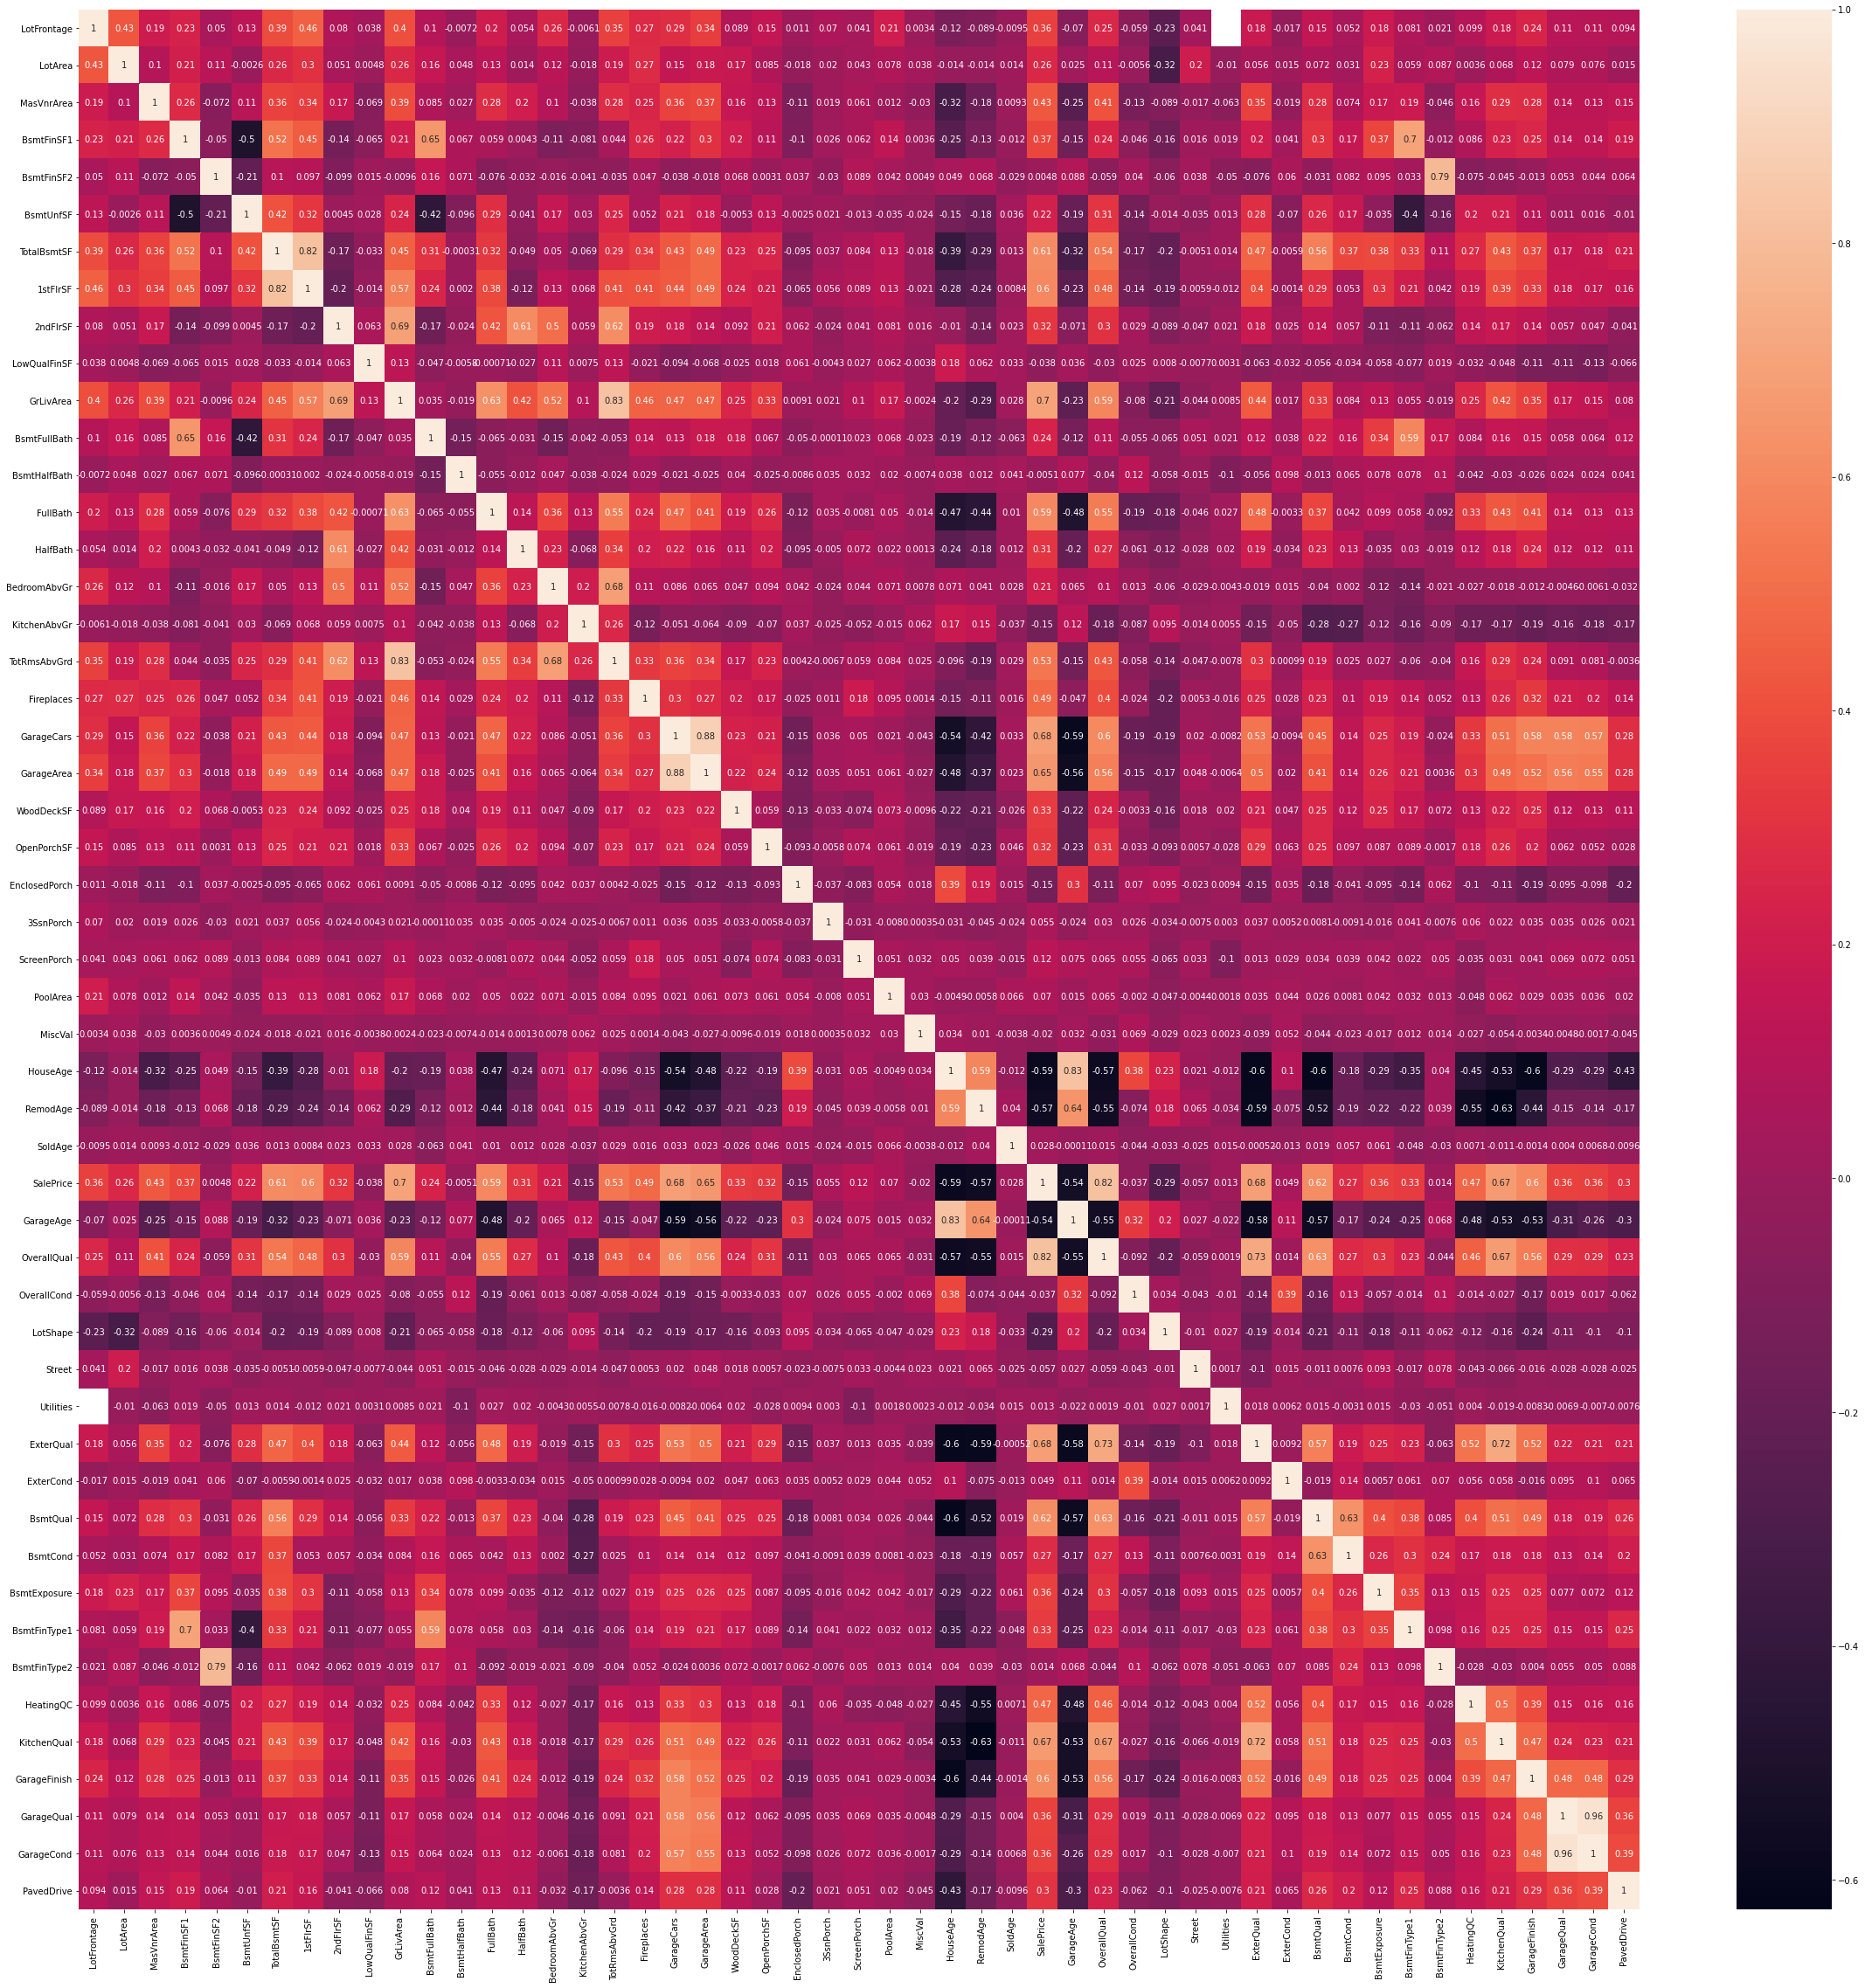

In [26]:
plt.figure(figsize=(40,40))
sns.heatmap(df_housing[numerical_columns].corr(),annot = True )

# LotArea is highly correlated with Lotfrontage,
#### TotalBsmtSF is highly corelated with 1stFlrSF
#### GrLivArea is highly corelated to 2ndFlrSF
#### BsmtFullBath is highly correlated with BsmtFinSF1
#### GrLivArea is highly corelated with TotRmsAbvGrd
#### TotRmsAbvGrd is highly BedroomAbvGr
#### GarageArea is highly corelated with GarageCars
#### HouseAge is highly correlated with GarageAge
#### RemodAge is highly correlated with GarageAge
#### OverallQual is highly correlated with ExterQual
#### BsmtSF1 is highly correlated BsmtFinType1
#### BsmtSF2 is highly correlated BsmtFinType2
#### OverallQual is highly correlated with KitchenQual
#### GarageQual is highly correlated GarageCond

In [27]:
df_housing = df_housing.drop(['LotFrontage','1stFlrSF','TotRmsAbvGrd','GarageCars','2ndFlrSF','BedroomAbvGr','BsmtFinSF1','GarageAge','RemodAge','ExterQual','BsmtFinType1','BsmtFinType2','KitchenQual','GarageCond'],axis = 1)
numerical_columns.remove('LotFrontage')
numerical_columns.remove('1stFlrSF')
numerical_columns.remove('2ndFlrSF')
numerical_columns.remove('BedroomAbvGr')
numerical_columns.remove('TotRmsAbvGrd')
numerical_columns.remove('GarageCars')
numerical_columns.remove('BsmtFinSF1')
numerical_columns.remove('GarageAge')
numerical_columns.remove('RemodAge')
numerical_columns.remove('ExterQual')
numerical_columns.remove('BsmtFinType1')
numerical_columns.remove('BsmtFinType2')
numerical_columns.remove('KitchenQual')
numerical_columns.remove('GarageCond')

# Again re-generate the heat map to verify there should not be any column with high correlation.

<AxesSubplot:>

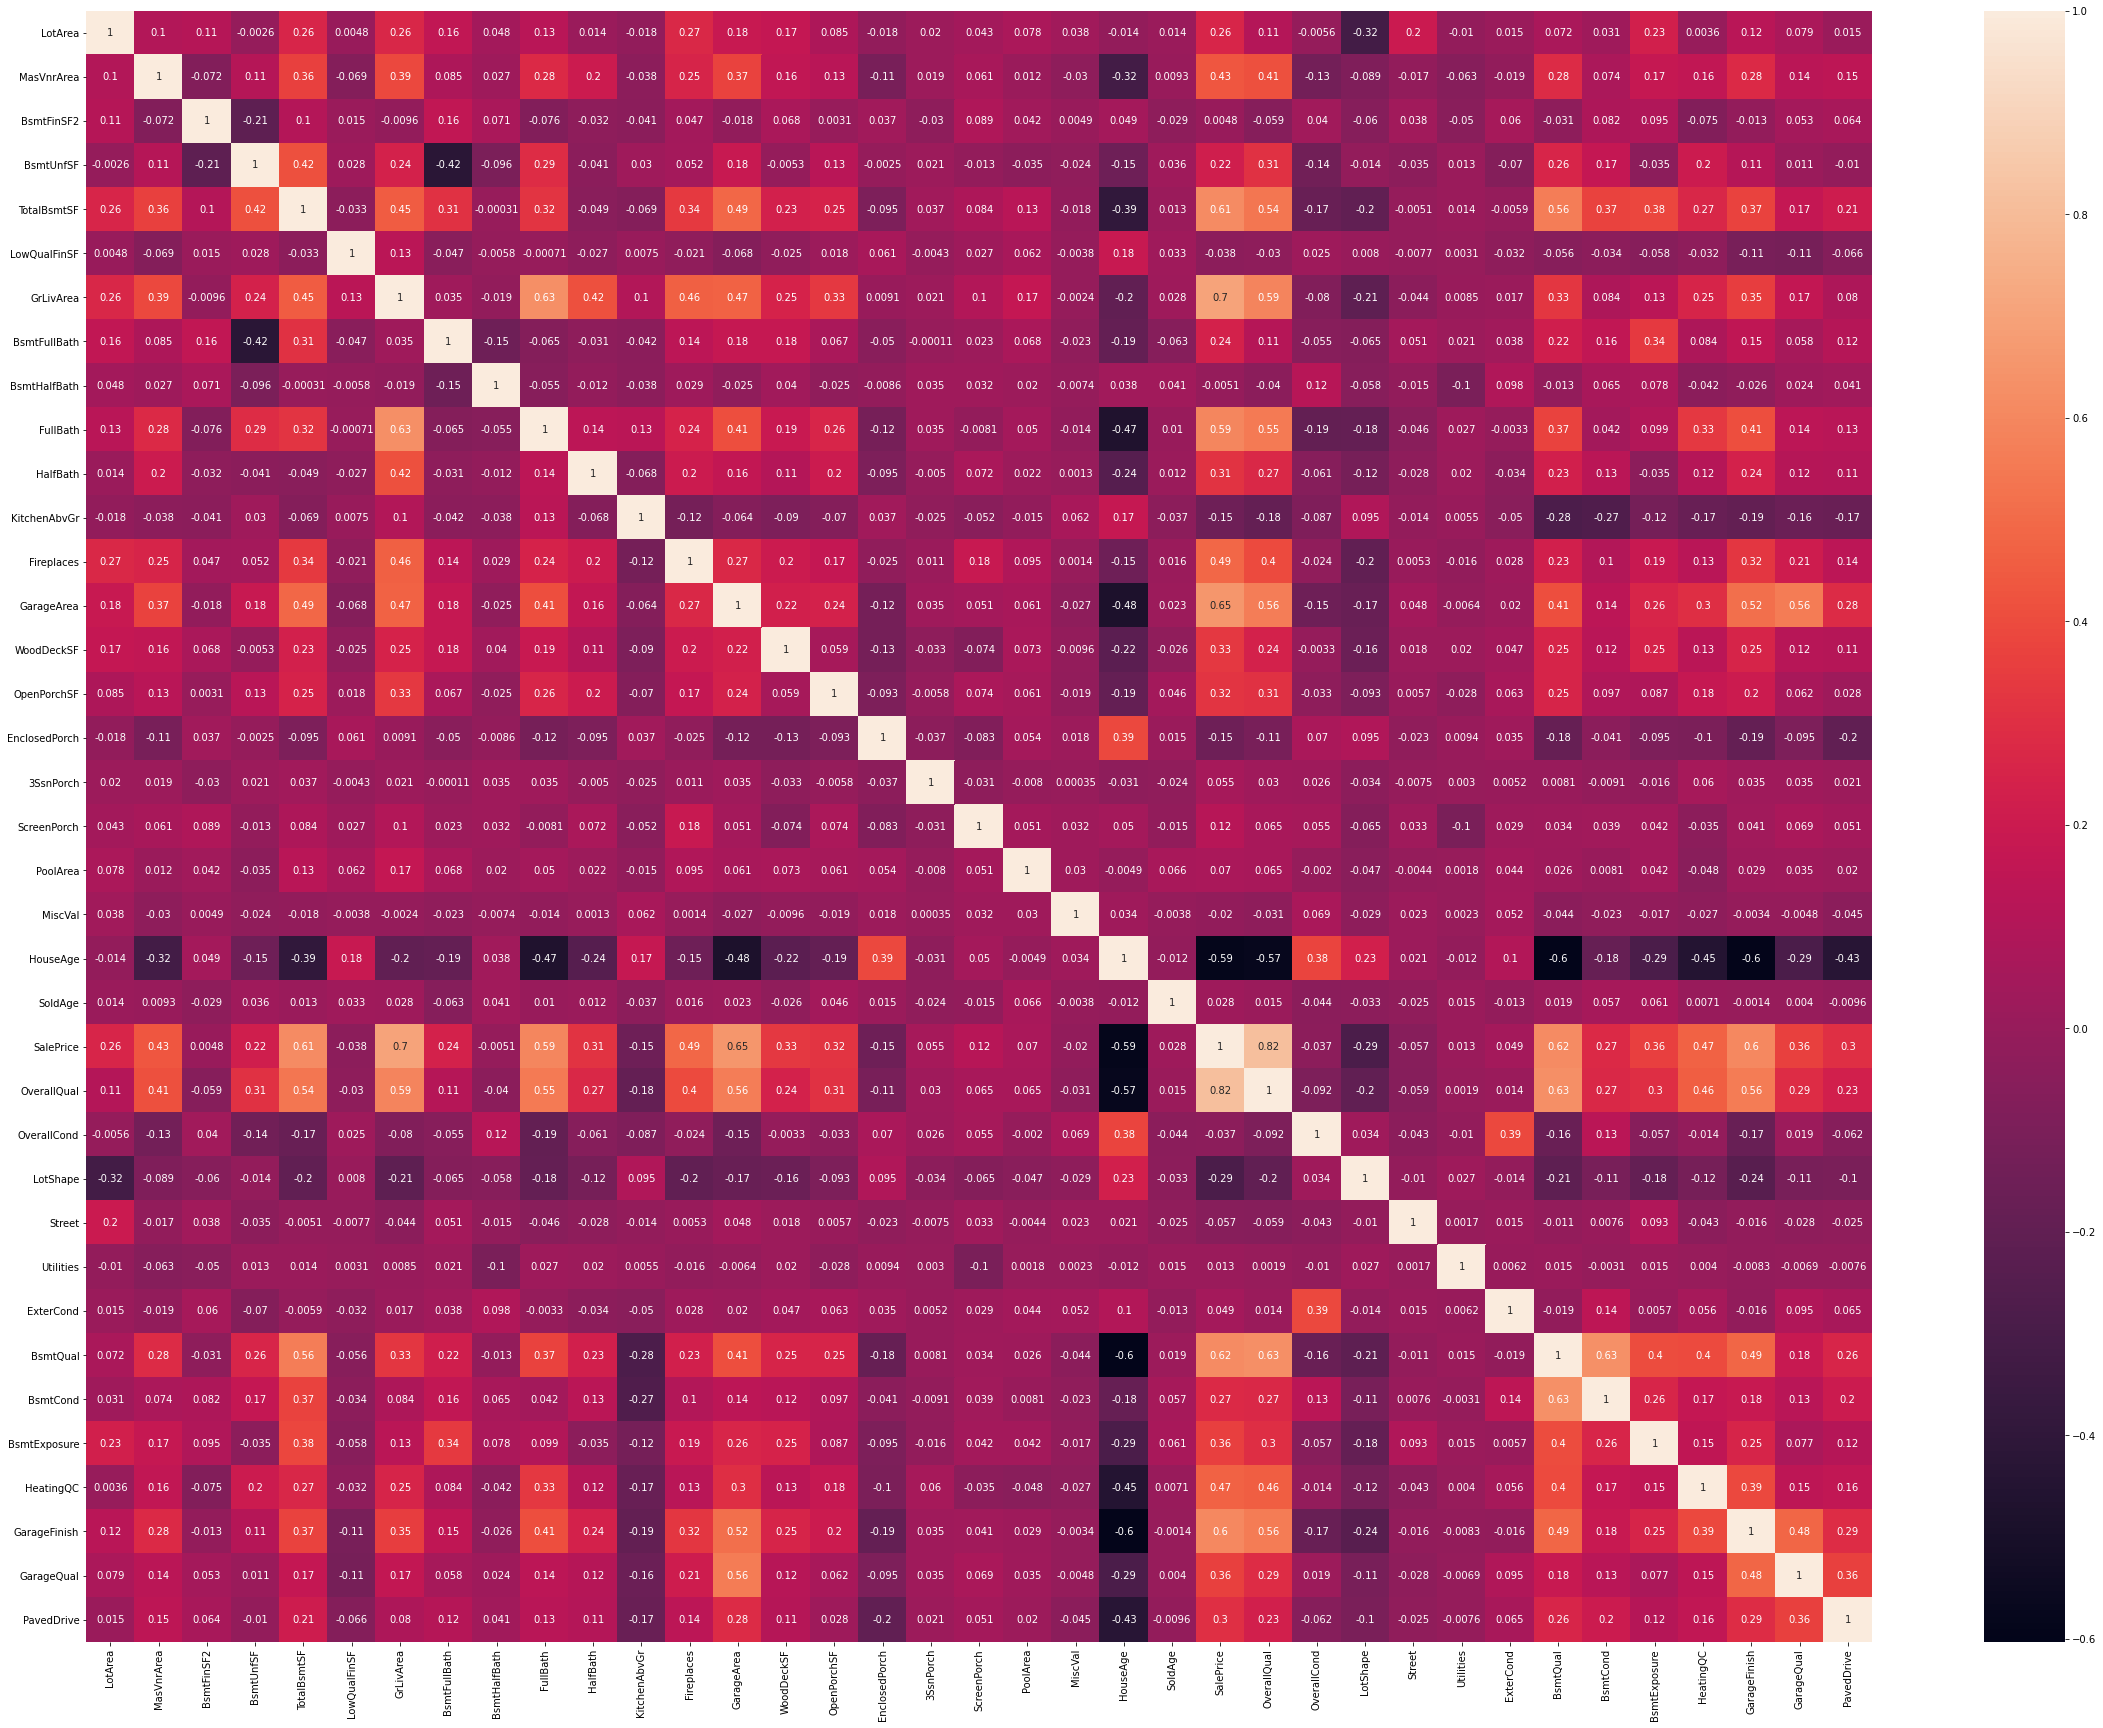

In [28]:
plt.figure(figsize=(40,30))
sns.heatmap(df_housing[numerical_columns].corr(),annot = True )

# Verify all numerical column should not have any null value

In [29]:
df_housing[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   MasVnrArea     1452 non-null   float64
 2   BsmtFinSF2     1460 non-null   int64  
 3   BsmtUnfSF      1460 non-null   int64  
 4   TotalBsmtSF    1460 non-null   int64  
 5   LowQualFinSF   1460 non-null   int64  
 6   GrLivArea      1460 non-null   int64  
 7   BsmtFullBath   1460 non-null   int64  
 8   BsmtHalfBath   1460 non-null   int64  
 9   FullBath       1460 non-null   int64  
 10  HalfBath       1460 non-null   int64  
 11  KitchenAbvGr   1460 non-null   int64  
 12  Fireplaces     1460 non-null   int64  
 13  GarageArea     1460 non-null   int64  
 14  WoodDeckSF     1460 non-null   int64  
 15  OpenPorchSF    1460 non-null   int64  
 16  EnclosedPorch  1460 non-null   int64  
 17  3SsnPorch      1460 non-null   int64  
 18  ScreenPo

# Analyze MasVnrArea column

In [30]:
df_housing['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

<AxesSubplot:xlabel='MasVnrArea', ylabel='Density'>

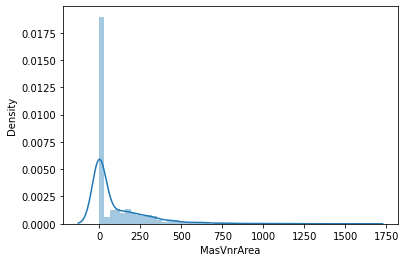

In [31]:
sns.distplot(df_housing['MasVnrArea'])

In [32]:
df_housing.drop('MasVnrArea',axis=1, inplace=True)
numerical_columns.remove('MasVnrArea')

# Drop all numerical columns where 75 percentile value is zero.

In [33]:
remove_colum_list = []
for col in numerical_columns:    
    if df_housing[col].quantile(0.75) == 0:
        print(col)
        df_housing = df_housing.drop(col,axis=1)
        remove_colum_list.append(col)
        
for col in remove_colum_list:
    numerical_columns.remove(col)

BsmtFinSF2
LowQualFinSF
BsmtHalfBath
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
Street


# Plot bar chart for all numerical columns.

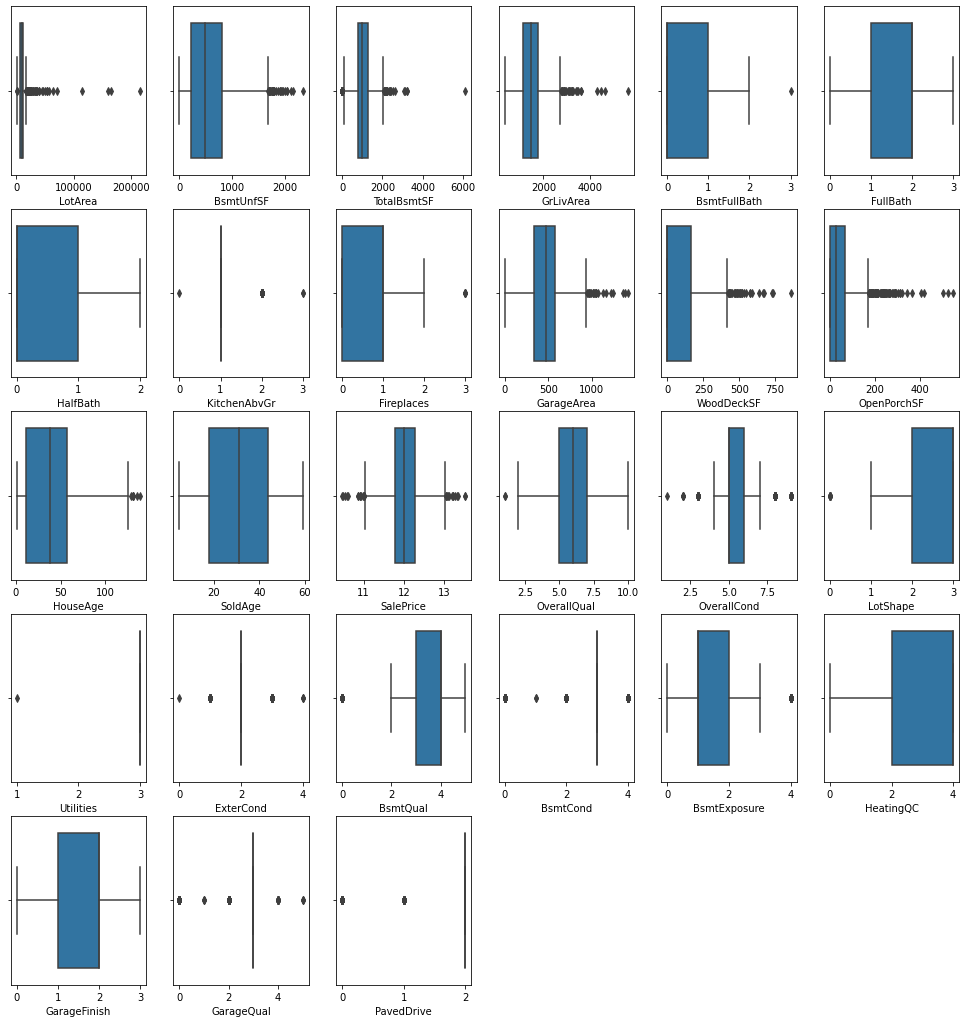

In [34]:
plt.figure(figsize=(17,18))
for index,col in enumerate(numerical_columns):
    plt.subplot(5,6,index + 1)
    sns.boxplot(df_housing[col])
plt.show()

# Analyzing LotArea and remove outlier based upon 95 percentile.

In [35]:
def remove_outlier(col):
    global df_housing
    q1 = df_housing[col].quantile(0.25)
    q3 = df_housing[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence= q1 - (1.5 * iqr)
    upper_fence= q3 + (1.5 * iqr)
    df_housing = df_housing[(df_housing[col] >= lower_fence) & (df_housing[col] <= upper_fence)]

In [36]:
df_housing = df_housing[df_housing['LotArea'] <= df_housing['LotArea'].quantile(0.95)]

In [37]:
df_housing = df_housing[df_housing['OpenPorchSF'] <= df_housing['OpenPorchSF'].quantile(0.95)]

# Analyze column KitchenAbvGr

In [38]:
df_housing.groupby('KitchenAbvGr')['KitchenAbvGr'].count()

KitchenAbvGr
0       1
1    1256
2      60
3       2
Name: KitchenAbvGr, dtype: int64

In [39]:
df_housing = df_housing.drop('KitchenAbvGr',axis = 1)
numerical_columns.remove('KitchenAbvGr')

# Analyze column Utilities

In [40]:
df_housing.groupby('Utilities')['Utilities'].count()

Utilities
1       1
3    1318
Name: Utilities, dtype: int64

In [41]:
df_housing = df_housing.drop('Utilities',axis = 1)
numerical_columns.remove('Utilities')

# Regenerate the bar graph for all numerical column and verify outlier.

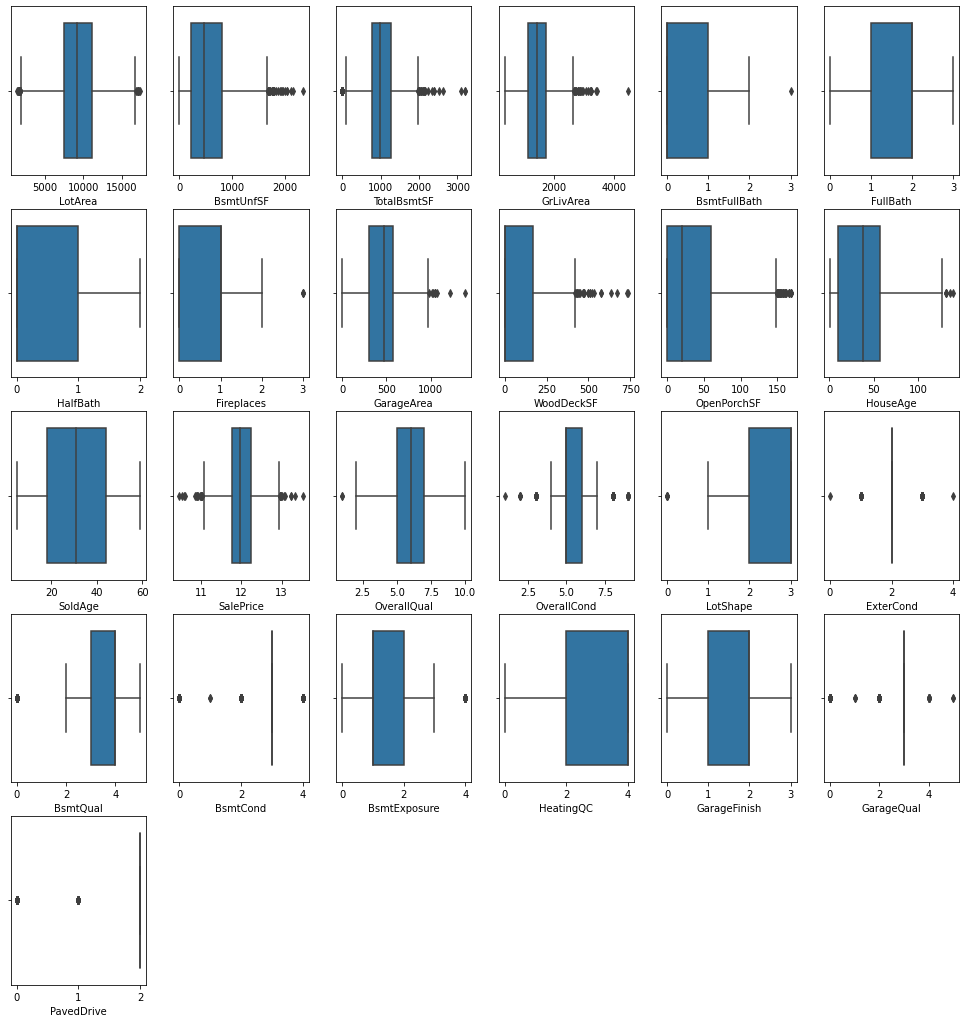

In [42]:
plt.figure(figsize=(17,18))
for index,col in enumerate(numerical_columns):
    plt.subplot(5,6,index + 1)
    sns.boxplot(df_housing[col])
plt.show()

# Analyze categorical columns

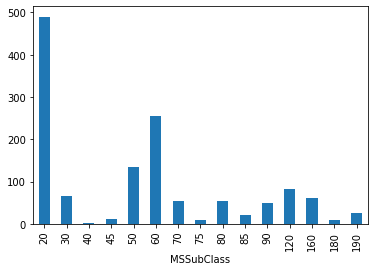

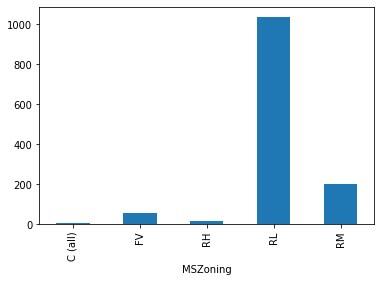

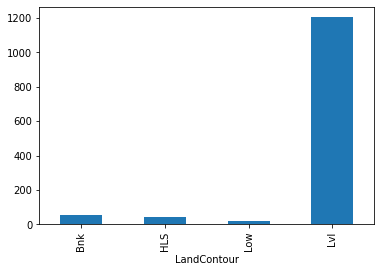

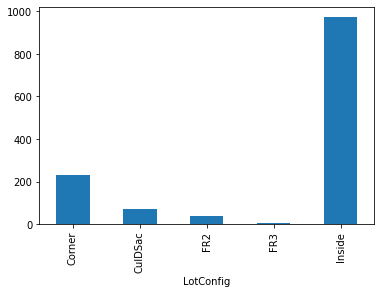

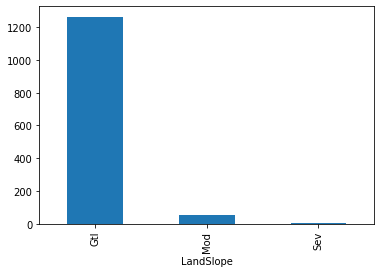

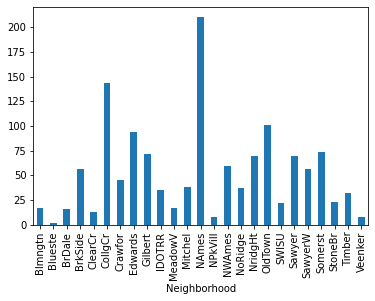

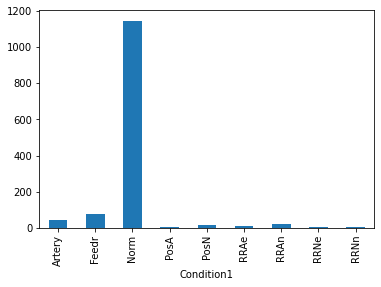

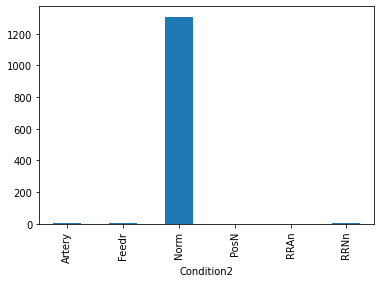

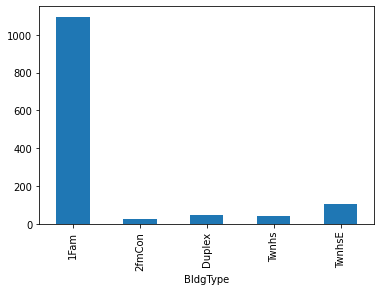

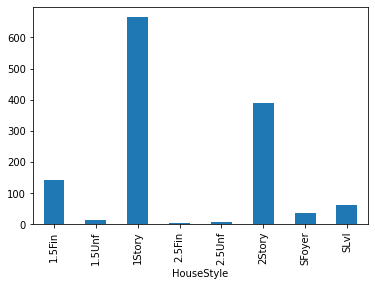

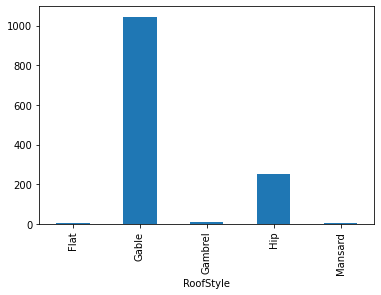

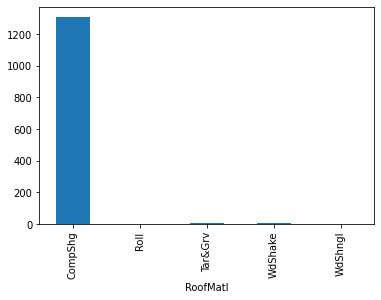

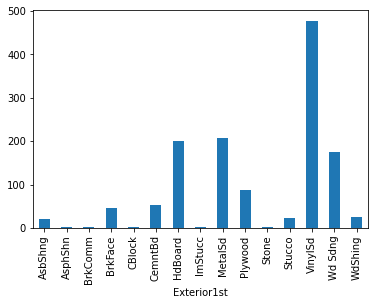

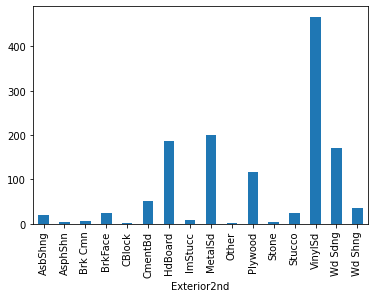

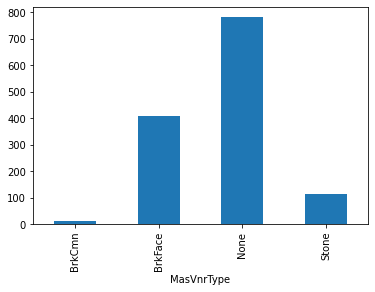

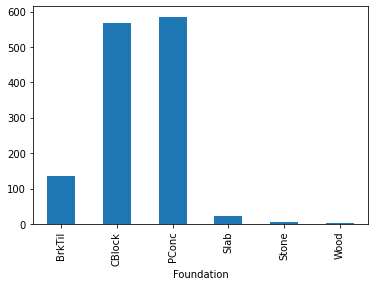

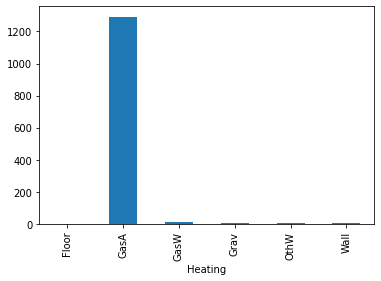

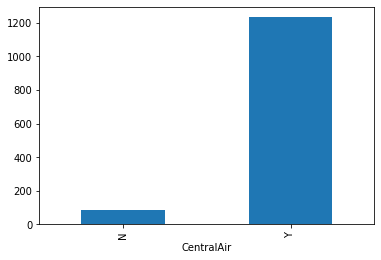

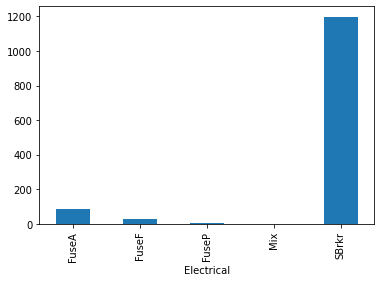

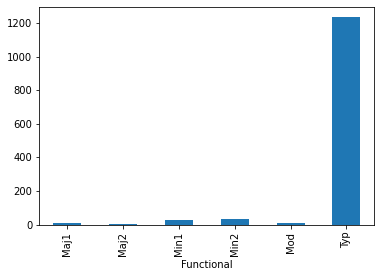

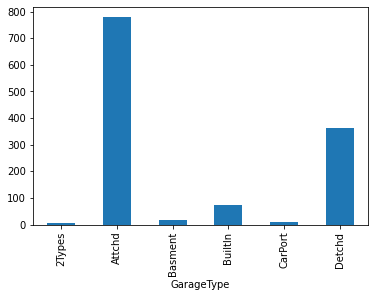

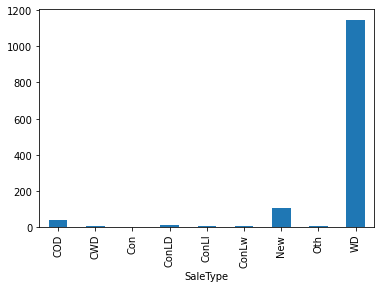

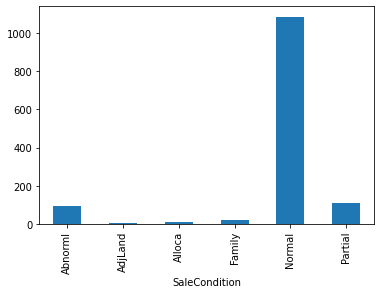

In [43]:
for col in categorical_columns:
    df_housing.groupby(col)[col].count().plot.bar()
    plt.show()

# Unbalanced data for LandContour

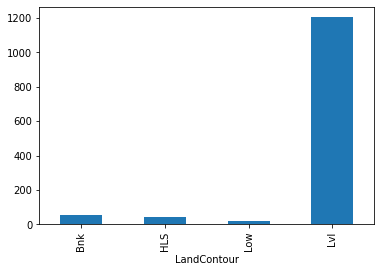

In [44]:
df_housing.groupby('LandContour')['LandContour'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('LandContour',axis = 1)
categorical_columns.remove('LandContour')

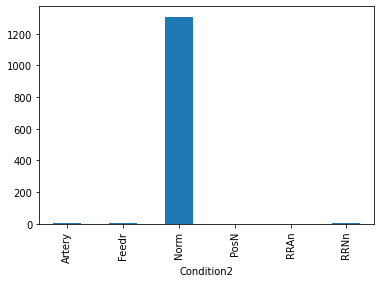

In [45]:
df_housing.groupby('Condition2')['Condition2'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('Condition2',axis = 1)
categorical_columns.remove('Condition2')

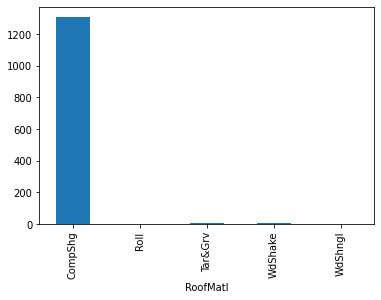

In [46]:
df_housing.groupby('RoofMatl')['RoofMatl'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('RoofMatl',axis = 1)
categorical_columns.remove('RoofMatl')

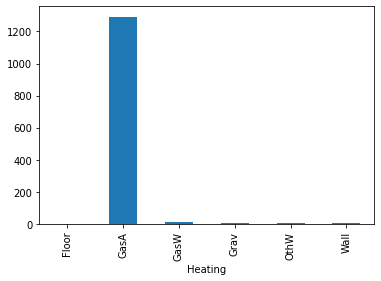

In [47]:
df_housing.groupby('Heating')['Heating'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('Heating',axis = 1)
categorical_columns.remove('Heating')

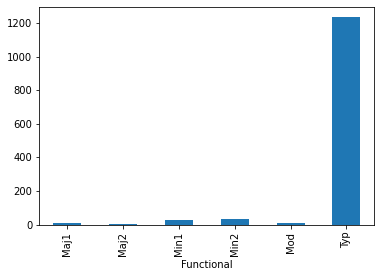

In [48]:
df_housing.groupby('Functional')['Functional'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('Functional',axis = 1)
categorical_columns.remove('Functional')

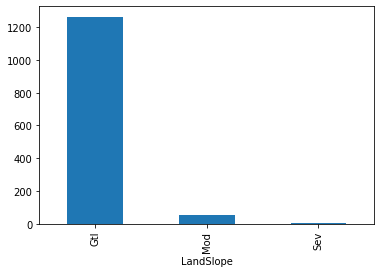

In [49]:
df_housing.groupby('LandSlope')['LandSlope'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('LandSlope',axis = 1)
categorical_columns.remove('LandSlope')

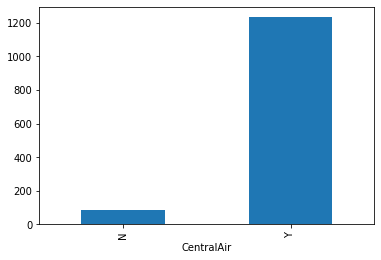

In [50]:
df_housing.groupby('CentralAir')['CentralAir'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('CentralAir',axis = 1)
categorical_columns.remove('CentralAir')

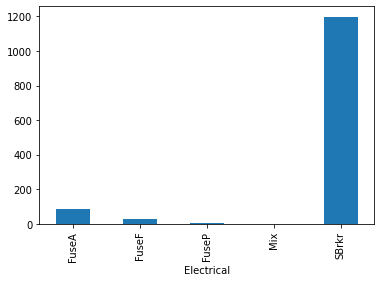

In [51]:
df_housing.groupby('Electrical')['Electrical'].count().plot.bar()
plt.show()
df_housing = df_housing.drop('Electrical',axis = 1)
categorical_columns.remove('Electrical')

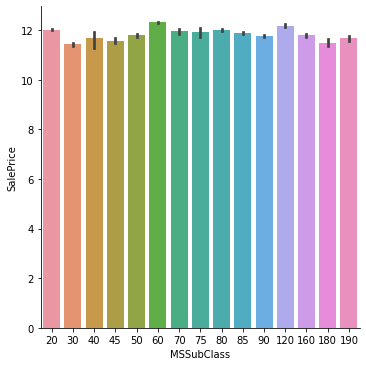

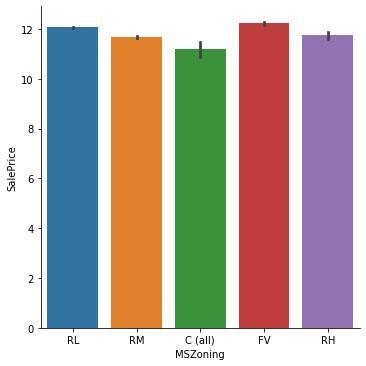

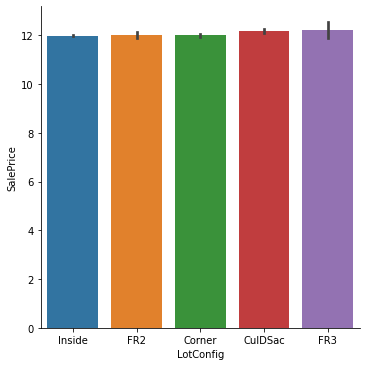

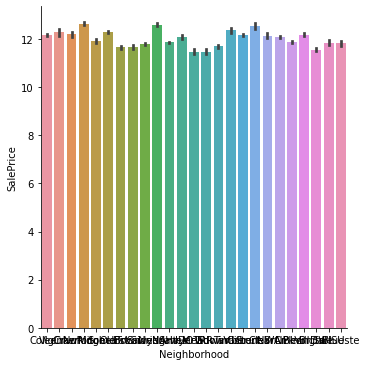

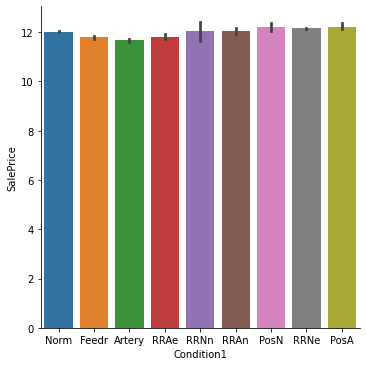

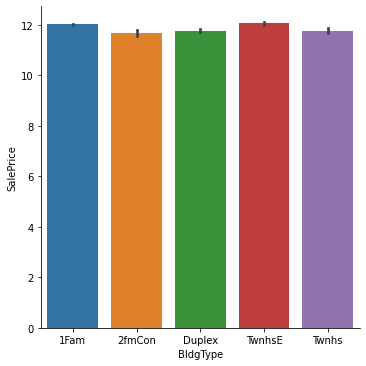

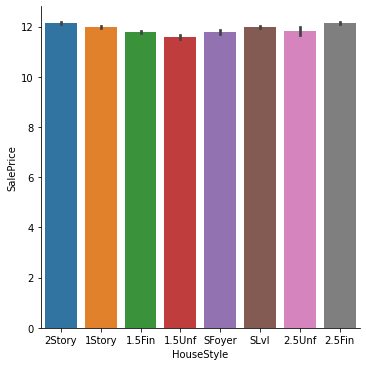

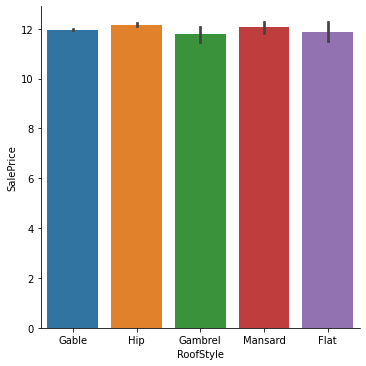

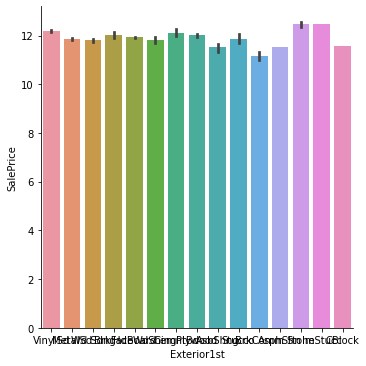

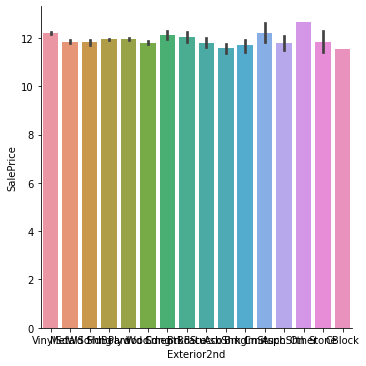

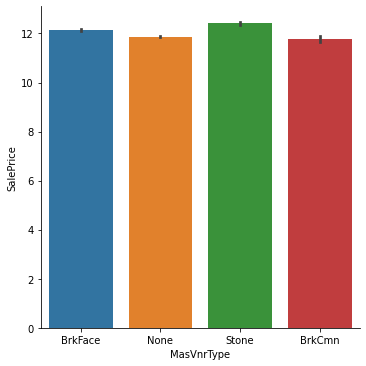

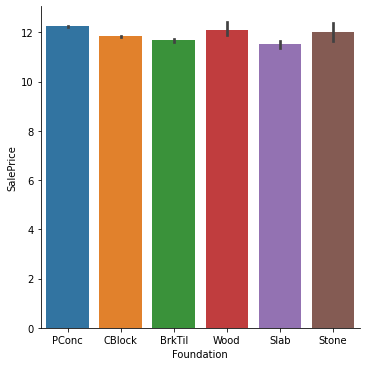

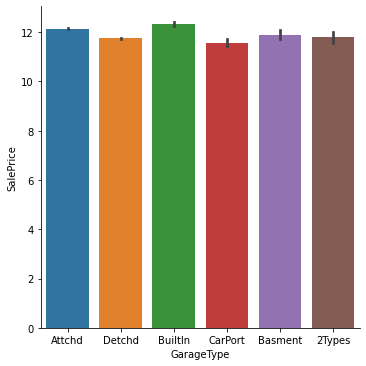

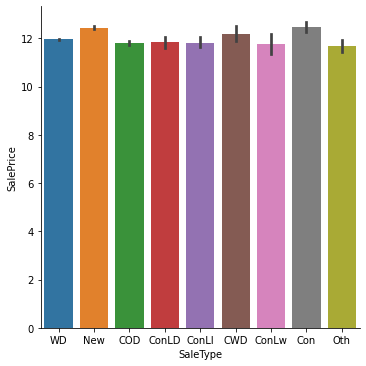

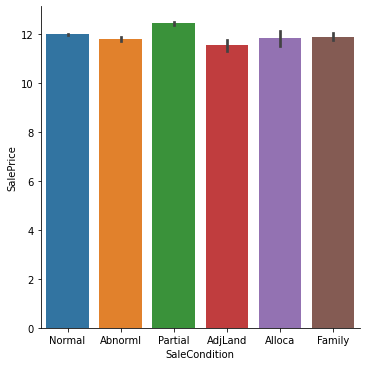

In [52]:
for index, col in enumerate(categorical_columns):
    sns.catplot(x=col,y = 'SalePrice',kind = 'bar', data=df_housing)
    plt.show()
    

# Verify all columns are converted to numerical column and there should not be any NULL value.

In [53]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1319 non-null   int64  
 1   MSZoning       1319 non-null   object 
 2   LotArea        1319 non-null   int64  
 3   LotShape       1319 non-null   int64  
 4   LotConfig      1319 non-null   object 
 5   Neighborhood   1319 non-null   object 
 6   Condition1     1319 non-null   object 
 7   BldgType       1319 non-null   object 
 8   HouseStyle     1319 non-null   object 
 9   OverallQual    1319 non-null   int64  
 10  OverallCond    1319 non-null   int64  
 11  RoofStyle      1319 non-null   object 
 12  Exterior1st    1319 non-null   object 
 13  Exterior2nd    1319 non-null   object 
 14  MasVnrType     1314 non-null   object 
 15  ExterCond      1319 non-null   int64  
 16  Foundation     1319 non-null   object 
 17  BsmtQual       1319 non-null   int64  
 18  BsmtCond

# Convert all categorical column into dummy

In [54]:
def convert_to_dummy(column):
    global df_housing
    df_housing[pd.get_dummies(df_housing[column],prefix=column,drop_first=True).columns] = pd.get_dummies(df_housing[column],prefix=column,drop_first=True)
    df_housing = df_housing.drop(column,axis=1)

In [55]:
for col in categorical_columns:
    convert_to_dummy(col)

# Split train test data into 80% vs 20%.

In [56]:
X = df_housing
y = X.loc[:,'SalePrice']
X = X.drop('SalePrice',axis = 1)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 20)

# Use RFE to reduce features to 50.

In [57]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,50)
rfe.fit(X_train,y_train)
list(zip(X_train,rfe.support_,rfe.ranking_))

[('LotArea', True, 1),
 ('LotShape', False, 80),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('ExterCond', False, 55),
 ('BsmtQual', False, 27),
 ('BsmtCond', False, 54),
 ('BsmtExposure', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('HeatingQC', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('FullBath', False, 37),
 ('HalfBath', False, 12),
 ('Fireplaces', True, 1),
 ('GarageFinish', False, 15),
 ('GarageArea', True, 1),
 ('GarageQual', True, 1),
 ('PavedDrive', False, 81),
 ('WoodDeckSF', False, 56),
 ('OpenPorchSF', False, 42),
 ('HouseAge', True, 1),
 ('SoldAge', False, 58),
 ('MSSubClass_30', False, 11),
 ('MSSubClass_40', False, 98),
 ('MSSubClass_45', True, 1),
 ('MSSubClass_50', False, 75),
 ('MSSubClass_60', False, 49),
 ('MSSubClass_70', True, 1),
 ('MSSubClass_75', False, 22),
 ('MSSubClass_80', False, 34),
 ('MSSubClass_85', False, 82),
 ('MSSubClass_90', False, 20),
 ('MSSubClass_120', False, 19),
 ('MSSubClass_160', True, 1)

In [58]:
col = X_train.columns[rfe.support_]
X_train = X_train[col]
X_test = X_test[col]

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055 entries, 62 to 474
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LotArea                1055 non-null   float64
 1   OverallQual            1055 non-null   float64
 2   OverallCond            1055 non-null   float64
 3   BsmtExposure           1055 non-null   float64
 4   BsmtUnfSF              1055 non-null   float64
 5   TotalBsmtSF            1055 non-null   float64
 6   HeatingQC              1055 non-null   float64
 7   GrLivArea              1055 non-null   float64
 8   BsmtFullBath           1055 non-null   float64
 9   Fireplaces             1055 non-null   float64
 10  GarageArea             1055 non-null   float64
 11  GarageQual             1055 non-null   float64
 12  HouseAge               1055 non-null   float64
 13  MSSubClass_45          1055 non-null   float64
 14  MSSubClass_70          1055 non-null   float64
 15  MSSu

# Remove columns using p_value > 0.05

In [60]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(list(y_train),X_train_sm)
lr_model = lr.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     271.1
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:05:37   Log-Likelihood:                 918.17
No. Observations:                1055   AIC:                            -1734.
Df Residuals:                    1004   BIC:                            -1481.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.99

# Try to remove columns using p_value methodology.

In [61]:
def get_higest_p_value_column():
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(list(y_train),X_train_sm)
    lr_model = lr.fit()
    max_p_value = 0
    max_index = 0 
    for index,p_value in enumerate(lr_model.pvalues):        
        if p_value > max_p_value and p_value > 0.05:
            max_p_value = p_value
            max_index = index            
    
    return X_train_sm.columns[max_index],max_p_value

In [62]:
while(True):
    col,p_value = get_higest_p_value_column()
    if p_value == 0:
        break
    print('Found ' + col + ' with p_value as ' + str(p_value) + ' and removing this column.')
    X_train.drop(col,axis = 1,inplace=True)
    X_test.drop(col,axis = 1,inplace=True)

Found MasVnrType_None with p_value as 0.14494566693710267 and removing this column.
Found HouseStyle_1.5Unf with p_value as 0.14788503713780032 and removing this column.
Found MSSubClass_45 with p_value as 0.32817071226198635 and removing this column.
Found Exterior1st_CemntBd with p_value as 0.09038155762030788 and removing this column.
Found BsmtFullBath with p_value as 0.0880145187089009 and removing this column.
Found MasVnrType_BrkFace with p_value as 0.06448784777756389 and removing this column.
Found Neighborhood_NAmes with p_value as 0.11013354719732554 and removing this column.
Found Exterior2nd_CmentBd with p_value as 0.05444790050311603 and removing this column.


# Verify p_values for all columns, it should  be less than 5.

In [63]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(list(y_train),X_train_sm)
lr_model = lr.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     318.3
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:05:37   Log-Likelihood:                 907.37
No. Observations:                1055   AIC:                            -1729.
Df Residuals:                    1012   BIC:                            -1515.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.99

# Use VIF to reduce columns

In [64]:
def get_VIF_top_column():
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif = vif.sort_values(by = 'VIF',ascending = False)
    if vif.iloc[0][1] > 5:
        return vif.iloc[0][0],vif.iloc[0][1]
    else:
        return 'None',0

In [65]:
while True:
    col,vif = get_VIF_top_column()
    if col == 'None':
        break
    print('Found VIF : ' + str(vif) +' for column ' + col  + ' and remove this column from train and test.')
    X_train = X_train.drop(col,axis = 1)
    X_test = X_test.drop(col,axis = 1)

Found VIF : 358.54301261109856 for column RoofStyle_Gable and remove this column from train and test.
Found VIF : 29.842375723711914 for column MSZoning_RL and remove this column from train and test.


# Verify VIF value for all comuns, it should not be greater that 5.

In [66]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by = 'VIF',ascending = False)
vif

,Features,VIF
11,HouseAge,4.631026
1,OverallQual,3.704057
9,GarageArea,2.625239
36,Foundation_PConc,2.512983
7,GrLivArea,2.454676
5,TotalBsmtSF,2.427070
16,MSZoning_RM,2.187510
39,SaleCondition_Partial,2.140426
0,LotArea,2.100349
22,Neighborhood_OldTown,1.940098


# LinearRegression

In [67]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_train_pred = lm.predict(X_train)
print('Training r2 score : ',metrics.r2_score(y_true=y_train,y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print('Test r2 score : ',metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

Training r2 score :  0.9234161933437464
Test r2 score :  0.9212830821591698


# Create a mthod to see r2_score graph vs alpha

In [68]:
def generate_r2_vs_alpha_graph(model):
    cv_results = pd.DataFrame(model.cv_results_)
    cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
    plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
    plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
    plt.xlabel('alpha')
    plt.ylabel('r2 score')
    plt.xscale('log')
    plt.show()

# Lasso 

In [69]:
params = {'alpha': [0.00005,0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100,200,300, 500, 1000 ]}

In [70]:

folds = KFold(n_splits=5, shuffle=True, random_state=40)
model = Lasso()
model_cv = GridSearchCV(estimator=model,param_grid=params,scoring='r2',cv=folds,return_train_score=True,verbose=1 )
model_cv.fit(X_train,y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
lasso_model = Lasso(alpha=alpha)        
lasso_model.fit(X_train, y_train) 
y_test_pred = lasso_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    1.1s finished


0.9232426808048069

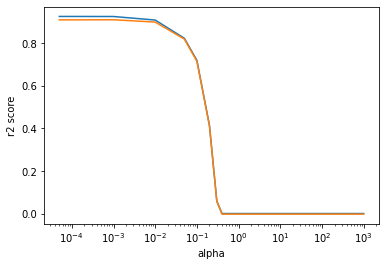

In [71]:
generate_r2_vs_alpha_graph(model_cv)

# Remove all column where coeffcient values are zero returned by Lasso.

In [72]:
train_columns = X_train.columns
column_to_remove = []
for index,coef in enumerate(lasso_model.coef_):
    #if abs(coef) <= 0.00000001: 
    if abs(coef) <= 0.001: 
        print(train_columns[index], coef)    
        X_train = X_train.drop(train_columns[index],axis = 1)
        X_test = X_test.drop(train_columns[index],axis = 1)
        
lasso_model = Lasso(alpha=alpha)        
lasso_model.fit(X_train, y_train) 
y_test_pred = lasso_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)

MSZoning_RH -0.0
RoofStyle_Hip -0.0


0.9232425819744308

# Ridge Regression

In [73]:
ridge_model = Ridge()
#folds = 5
folds = KFold(n_splits=5, shuffle=True, random_state=40)
model_cv = GridSearchCV(estimator = ridge_model, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train) 
y_test_pred = ridge_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    0.9s finished


0.9217793218537487

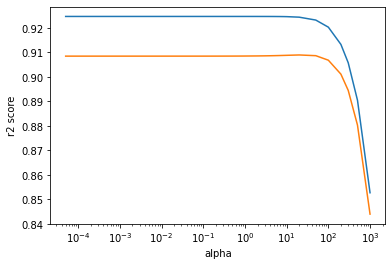

In [74]:
generate_r2_vs_alpha_graph(model_cv)

# Elastic Net

In [75]:
elasticnet = ElasticNet()
folds = KFold(n_splits=5, shuffle=True, random_state=40)
model_cv = GridSearchCV(estimator = elasticnet, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 
cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
elastic_net_model = ElasticNet(alpha=alpha)
elastic_net_model.fit(X_train, y_train)
y_test_pred = elastic_net_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)  

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    0.9s finished


0.9224269608905865

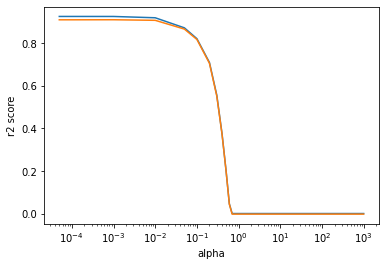

In [76]:
generate_r2_vs_alpha_graph(model_cv)

# Forward Feature Selection

In [77]:
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + np.log(n) * num_params
    return bic

In [78]:
features = X_train.columns

regression = LinearRegression()

selected_features = []
min_aic = np.inf
for step in range(0, 11, 1):
    for feature in features:        
        testing_features = selected_features + [feature]
        regression.fit(X_train[testing_features], y_train)
        y_pred = regression.predict(X_test[testing_features])
        mse = metrics.mean_squared_error(y_test, y_pred)
        num_params = len(regression.coef_) + 1  # features and intercept
        n = X_train.shape[0]
        aic = calculate_aic(n, mse, num_params)
        bic = calculate_bic(n, mse, num_params)
        if aic < min_aic:
            min_aic = aic
            current_bic = bic
            best_feature = feature
        
    selected_features = selected_features + [best_feature]
    print("Selected features: ", selected_features, "\nAIC: ", min_aic, "\nBIC: ", current_bic)


y_pred = regression.predict(X_test[selected_features])
print("\n\nFinal r-squared: ", metrics.r2_score(y_test, y_pred))

Selected features:  ['OverallQual'] 
AIC:  -3316.4389350680453 
BIC:  -3306.516342976225
Selected features:  ['OverallQual', 'GrLivArea'] 
AIC:  -3696.7008167815493 
BIC:  -3681.8169286438188
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF'] 
AIC:  -3920.7838471315954 
BIC:  -3900.9386629479545
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'HouseAge'] 
AIC:  -4075.22414984055 
BIC:  -4050.4176696109994
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'HouseAge', 'OverallCond'] 
AIC:  -4346.865193335176 
BIC:  -4317.097417059715
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'HouseAge', 'OverallCond', 'LotArea'] 
AIC:  -4454.185143649405 
BIC:  -4419.456071328034
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'HouseAge', 'OverallCond', 'LotArea', 'BsmtUnfSF'] 
AIC:  -4546.28602896761 
BIC:  -4506.595660600328
Selected features:  ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'HouseAge', 'OverallCond', 'LotArea

# Use only these 11 features and again run Lasso and Ridge

In [79]:
selected_features = list(set(selected_features))
len(selected_features)
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Create a metod to sort the fetures based upon coeffcients.

In [80]:
def sort_coeff(x):
    return np.abs(x[1])

def display_sorted_coeff(coef):
    coeff_list  = []
    for index,coef in enumerate(coef):
        coeff_list.append([X_train.columns[index], coef])
    coeff_list = sorted(coeff_list, key=sort_coeff,reverse=True)
    for index,coef in enumerate(coeff_list):
        print(coeff_list[index][0],coeff_list[index][1])

# Lasso

In [81]:
folds = KFold(n_splits=5, shuffle=True, random_state=40)
model = Lasso()
model_cv = GridSearchCV(estimator=model,param_grid=params,scoring='r2',cv=folds,return_train_score=True,verbose=1 )
model_cv.fit(X_train,y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
lasso_model = Lasso(alpha=alpha)        
lasso_model.fit(X_train, y_train) 
y_test_pred = lasso_model.predict(X_test)
print('Lasso with Alpha value : ' + str(alpha) + ' With r2_score : '+ str(metrics.r2_score(y_true=y_test,y_pred=y_test_pred)))
display_sorted_coeff(lasso_model.coef_)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Lasso with Alpha value : 0.001 With r2_score : 0.9255866090293933
GrLivArea 0.12834309748614434
OverallQual 0.11345969076916328
HouseAge -0.1060454689506457
TotalBsmtSF 0.08586425471284576
OverallCond 0.057570999765343446
BsmtUnfSF -0.044128024963153635
GarageArea 0.0371918595168843
LotArea 0.029561882687083887
Neighborhood_Crawfor 0.02773143743031501
SaleCondition_Partial 0.022966088354413144
MSZoning_RM -0.01484744706866118


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    0.7s finished


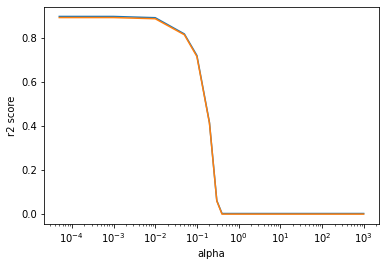

In [82]:
generate_r2_vs_alpha_graph(model_cv)

# Ridge

In [83]:
ridge_model = Ridge()
folds = KFold(n_splits=5, shuffle=True, random_state=40)
model_cv = GridSearchCV(estimator = ridge_model, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train) 
y_test_pred = ridge_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)
print('Ridge with Alpha value : ' + str(alpha) + ' With r2_score : '+ str(metrics.r2_score(y_true=y_test,y_pred=y_test_pred)))

display_sorted_coeff(ridge_model.coef_)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge with Alpha value : 20 With r2_score : 0.9253715174474254
GrLivArea 0.12622384751038696
OverallQual 0.11325038655775513
HouseAge -0.10401581875826343
TotalBsmtSF 0.08542033422374426
OverallCond 0.05699142125195163
BsmtUnfSF -0.043906483257067135
GarageArea 0.03893072004658958
LotArea 0.030028101742606207
Neighborhood_Crawfor 0.0281645353453719
SaleCondition_Partial 0.023902535015944894
MSZoning_RM -0.01599006609779512


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    0.8s finished


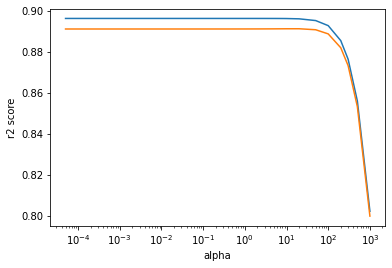

In [84]:
generate_r2_vs_alpha_graph(model_cv)

# Elasticnet

In [85]:
elasticnet = ElasticNet()
folds = KFold(n_splits=5, shuffle=True, random_state=40)
# cross validation
model_cv = GridSearchCV(estimator = elasticnet, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 
cv_results = pd.DataFrame(model_cv.cv_results_)
alpha = cv_results[cv_results['rank_test_score'] == 1]['param_alpha'].iloc[0]
elastic_net_model = ElasticNet(alpha=alpha)
elastic_net_model.fit(X_train, y_train)
y_test_pred = elastic_net_model.predict(X_test)
metrics.r2_score(y_true=y_test,y_pred=y_test_pred)  
print('ElasticNet with Alpha value : ' + str(alpha) + ' With r2_score : '+ str(metrics.r2_score(y_true=y_test,y_pred=y_test_pred)))

display_sorted_coeff(elastic_net_model.coef_)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet with Alpha value : 0.001 With r2_score : 0.9256769154539413
GrLivArea 0.12867736392813214
OverallQual 0.11320408498799282
HouseAge -0.10651587880348648
TotalBsmtSF 0.08643262235511566
OverallCond 0.05821965641449066
BsmtUnfSF -0.04503550912979285
GarageArea 0.03726023718354562
LotArea 0.02969845558741196
Neighborhood_Crawfor 0.028104212778476995
SaleCondition_Partial 0.023544753978072742
MSZoning_RM -0.014987894687120603


[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:    0.7s finished


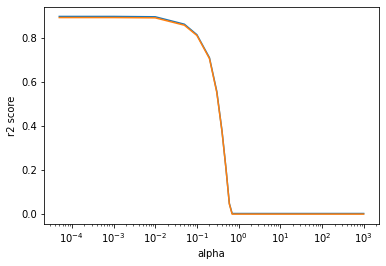

In [86]:
generate_r2_vs_alpha_graph(model_cv)

# Conclusion -
## Following 11 variables are significant in predicting the price of a house.

##### 1. GrLivArea
##### 2. OverallQual
##### 3. HouseAge
##### 4. TotalBsmtSF
##### 5. OverallCond
##### 6. BsmtUnfSF
##### 7. GarageArea
##### 8. LotArea
##### 9. Neighborhood_Crawfor
##### 10. SaleCondition_Partial
##### 11. MSZoning_RM

#### =========================================================================================================

# Lasso 
### Alpha value                     : 0.001
### r2_score                          : 0.9255905048438424

## Coeffcients
### GrLivArea 0.12835007520263955
### OverallQual 0.11347469189987112
### HouseAge -0.1060285569264513
### TotalBsmtSF 0.08586380034869286
### OverallCond 0.0575668151265383
### BsmtUnfSF -0.044129793811226156
### GarageArea 0.03718556658072619
### LotArea 0.02955272370814928
### Neighborhood_Crawfor 0.027723593203061597
### SaleCondition_Partial 0.02297390864827762
### MSZoning_RM -0.014863604477114808



#### =========================================================================================================

# Ridge
### Alpha value                     : 20
### r2_score                          : 0.9253715174474254
## Coeffcients
### GrLivArea 0.12622384751038707
### OverallQual 0.11325038655775492
### HouseAge -0.10401581875826338
### TotalBsmtSF 0.08542033422374427
### OverallCond 0.05699142125195148
### BsmtUnfSF -0.043906483257067086
### GarageArea 0.03893072004658967
### LotArea 0.030028101742606148
### Neighborhood_Crawfor 0.028164535345371985
### SaleCondition_Partial 0.02390253501594488
### MSZoning_RM -0.015990066097795123


#### =========================================================================================================
# ElasticNet
### Alpha value                    : 0.0001
### r2_score                         : 0.9257518697469902
## Coeffcients
### GrLivArea 0.12868443255773823
### OverallQual 0.11321891318829251
### HouseAge -0.10649941945322952
### TotalBsmtSF 0.08643206939076477
### OverallCond 0.05821550727046987
### BsmtUnfSF -0.04503714757182105
### GarageArea 0.037253750362995997
### LotArea 0.029689472934590715
### Neighborhood_Crawfor 0.028096432015703336
### SaleCondition_Partial 0.023552421752646446
### MSZoning_RM -0.015003807411095024


In [87]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
for col in X_train.columns:
    X_train[col] =  X_train['LotArea'].astype(int)
    X_test[col] =  X_test['LotArea'].astype(int)

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
metrics.r2_score(y_test,y_pred)